## Imports

In [1]:
import copy
import numpy as np
import pandas as pd
import multiprocessing
import matplotlib.pyplot as plt

import defs
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## Loading Dataset

In [2]:
n_features = 9

In [3]:
dataset = pd.read_csv("Resources/glass.scale.txt", header=None)

In [4]:
# dataset_test = pd.read_csv("Resources/pendigits.t", header=None)

In [5]:
dataset.head()

,0
0,1 1:-0.134323 2:-0.124812 3:1 4:-0.495327 5:-0...
1,1 1:-0.432839 2:-0.0496238 3:0.603564 4:-0.333...
2,1 1:-0.55838 2:-0.157895 3:0.581292 4:-0.22118...
3,1 1:-0.428443 2:-0.254135 3:0.643653 4:-0.3769...
4,1 1:-0.449511 2:-0.23609 3:0.612472 4:-0.4081 ...


In [6]:
dataset[0][0]

'1 1:-0.134323 2:-0.124812 3:1 4:-0.495327 5:-0.296429 6:-0.980676 7:-0.3829 8:-1 9:-1 '

In [7]:
dataset.shape #, dataset_test.shape

(214, 1)

In [8]:
def get_dataset(dataset):
    X = []
    y = []

    for idx, i in enumerate(dataset[0]):
        k = [0] * n_features
        p = i.strip().split(" ")
        y.append(int(p[0]))
        for j in p[1:]:
            k[int(j.split(":")[0])-1] = float(j.split(":")[1])
        X.append(k)
    return np.array(X), np.array(y)

In [9]:
X_raw, y = get_dataset(dataset)

In [10]:
np.unique(y)

array([1, 2, 3, 5, 6, 7])

In [11]:
y -= 1

In [12]:
n_classes = np.unique(y).shape[0] + 1

In [13]:
n_classes

7

In [14]:
X_raw.shape, y.shape

((214, 9), (214,))

In [15]:
np.unique(y)

array([0, 1, 2, 4, 5, 6])

In [16]:
n_classes

7

In [17]:
# X_test_raw, y_test = get_dataset(dataset_test)

In [18]:
# X_test_raw.shape, y_test.shape

In [19]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.3, random_state=42)

In [20]:
pca = PCA(n_components=2)

In [21]:
X_train = pca.fit_transform(X_train_raw)

In [22]:
X_test = pca.transform(X_test_raw)

In [23]:
pca.explained_variance_ratio_

array([0.4409326 , 0.18963278])

# Required Methods

#### Plot

In [24]:
def plot_tsne(X, y):
    tsne = TSNE(n_components=2, random_state=0)
    k = tsne.fit_transform(X)
    scatter = plt.scatter(k[:, 0], k[:, 1], c=y)
    plt.legend(*scatter.legend_elements(num=np.unique(y)), loc="upper right", title="Classes")
    plt.show()

#### Kernels

In [25]:
def linear_kernel(x, y, c=2):
    return np.dot(x, y.T) + c

In [26]:
def rbf_kernel(X, y, sigma = 3):
    K = np.zeros((X.shape[0], y.shape[0]))
    for i, x_ in enumerate(X):
        for j, y_ in enumerate(y):
            K[i, j] = np.linalg.norm(x_-y_)**2
    return np.exp(-(1.0/2.0*(sigma**2))*K)

In [27]:
def predcit_proba(X, svm_s):
    y_proba = []

    for clf in svm_s:
        y_proba.append(clf.predict_proba(X)[:, 1].tolist())
    return np.array(y_proba).T

In [28]:
def predcit(X, svm_s):
    y_proba = []

    for clf in svm_s:
        y_proba.append(clf.predict(X).tolist())
    return np.array(y_proba).T

### OVR

In [29]:
def ovr_multiclass_convert(y_predic):
    y_predicted = []
    
    for y_data in y_predic:
        y_predicted.append(np.argmax(y_data, axis = 0))
        
    return np.array(y_predicted)

In [30]:
def ovr_get_svm(X, y, kernel, probability, i, gamma):
    y_ = copy.deepcopy(y)

    y_[y_== i] = -1
    y_[y_!= -1] = 0
    y_[y_== -1] = 1

    model = SVC(kernel=kernel, gamma=gamma, probability=probability)
    model.fit(X, y_)
    return model

In [31]:
def ovr_fit(X, y, probability, kernel, gamma='auto'):
        
#     grid = []
#     for i in np.unique(y_train):
#         grid.append((X_train, y_train, kernel, probability, i))
    
#     pool = multiprocessing.Pool()
#     svm_all = pool.starmap(defs.ovr_svm_multipro, grid)

    svm_all = []
    for i in np.unique(y):
        svm_all.append(ovr_get_svm(X, y, kernel, probability, i, gamma))
    return svm_all

In [32]:
def ovr_predict(X, svm_all):
    y_proba = predcit_proba(X, svm_all)
    return ovr_multiclass_convert(y_proba)

In [33]:
def ovr_score(X, y, svm_all):
    return accuracy_score(ovr_predict(X, svm_all), y)

### OVO

In [34]:
def ovo_multiclass_convert(y):
    y_predicted = []

    for p in y:
        val = [0] * n_classes
        for i in range(0, len(p)):
            if p[i] <= 0:
                val[combinations[i][0]]= val[combinations[i][0]]+1
            else:
                val[combinations[i][1]]= val[combinations[i][1]]+1
        y_predicted.append(val.index(max(val)))
    
    return np.array(y_predicted)

In [35]:
def ovo_fit(X_train, y_train, kernel, gamma='auto'):
    combinations = []
    for i in np.unique(y_train):
        for j in np.unique(y_train):
            if i < j:
                combinations.append([i,j])

    grid = []
    for i, j in combinations:
        grid.append((X_train, y_train, kernel, i, j, gamma))

    pool = multiprocessing.Pool()
    svm_all = pool.starmap(defs.ovo_svm_multipro, grid)
    pool.close()
    return svm_all, combinations

In [36]:
def ovo_predict(X, svm_all):
    y_proba = predcit(X, svm_all)
    return ovo_multiclass_convert(y_proba)

In [37]:
def ovo_score(X, y, svm_all):
    return accuracy_score(ovo_predict(X, svm_all), y)

### OVR Plot

In [38]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    return xx, yy

In [39]:
def draw_plot(X, y, svm_all, predict):
    y_predicted = predict(X, svm_all)

    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    Z = predict(np.c_[xx.ravel(), yy.ravel()], svm_all)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.winter)
    scatter = plt.scatter(X0, X1, c=y, cmap=plt.cm.Paired, edgecolors='k')
    plt.legend(*scatter.legend_elements(num=np.unique(y)), loc="upper left", title="Classes")
    plt.show()

## Analysis

//anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


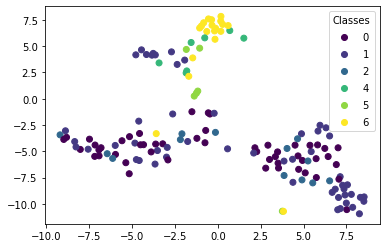

In [40]:
plot_tsne(X_train, y_train)

//anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


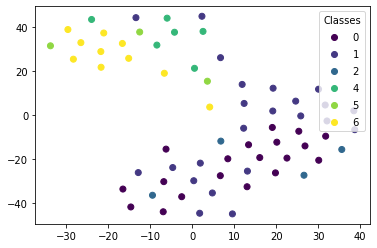

In [41]:
plot_tsne(X_test, y_test)

# Baselines

In [42]:
svm = SVC(kernel='linear', gamma='auto')
svm.fit(X_train, y_train)
print(svm.score(X_train, y_train))
print(svm.score(X_test, y_test))

0.5033557046979866
0.5230769230769231


In [43]:
svm = SVC(kernel='rbf', gamma='auto')
svm.fit(X_train, y_train)
print(svm.score(X_train, y_train))
print(svm.score(X_test, y_test))

0.5369127516778524
0.6


In [44]:
svm

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

# Models
- OVR - Linear and RBF
- AVA - Linear and RBF

## OVR

In [45]:
probability = True

### kernel = 'linear'

In [46]:
clf = ovr_fit(X_train, y_train, probability, kernel=linear_kernel)

In [47]:
ovr_score(X_train, y_train, clf)

0.3087248322147651

In [48]:
ovr_score(X_test, y_test, clf)

0.3230769230769231

//anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


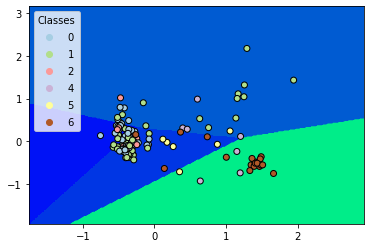

In [49]:
draw_plot(X_train, y_train, clf, ovr_predict)

### RBF Picking best gamma

In [50]:
gamma_grid = [1, 10, 100, 1000, 10000]

Gamma: 1
Train Accuracy 0.4563758389261745
Test Accuracy 0.5384615384615384


//anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


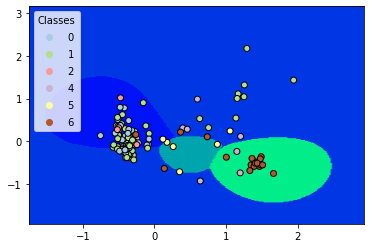


Gamma: 10
Train Accuracy 0.5369127516778524
Test Accuracy 0.5230769230769231


//anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


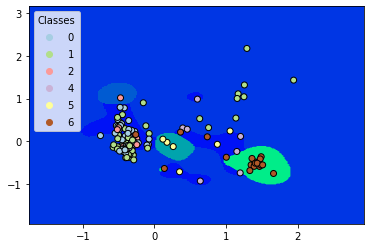


Gamma: 100
Train Accuracy 0.6241610738255033
Test Accuracy 0.4153846153846154


//anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


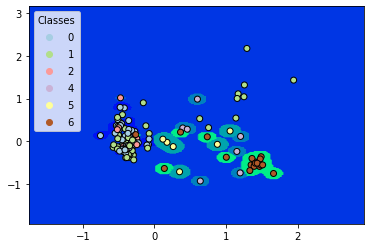


Gamma: 1000
Train Accuracy 0.7046979865771812
Test Accuracy 0.5076923076923077


//anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


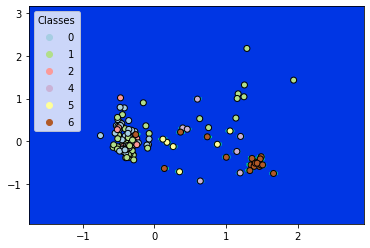


Gamma: 10000
Train Accuracy 0.697986577181208
Test Accuracy 0.4153846153846154


//anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


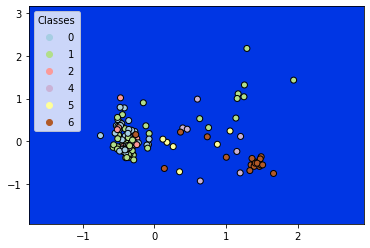

In [51]:
for gamma in gamma_grid:
    print("Gamma:", gamma)
    clf = ovr_fit(X_train, y_train, probability, kernel='rbf', gamma=gamma)
    print("Train Accuracy", ovr_score(X_train, y_train, clf))
    print("Test Accuracy", ovr_score(X_test, y_test, clf))
    draw_plot(X_train, y_train, clf, ovr_predict)
    print("")

## Best gamma: 1 or 10

### kernel = 'RBF'

In [52]:
clf = ovr_fit(X_train, y_train, probability, kernel='rbf', gamma=10)

In [53]:
ovr_score(X_train, y_train, clf)

0.5167785234899329

In [54]:
ovr_score(X_test, y_test, clf)

0.5230769230769231

//anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


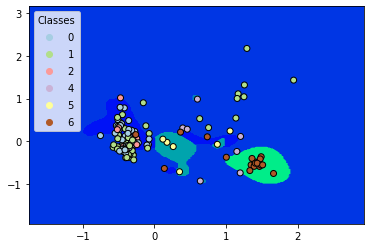

In [55]:
draw_plot(X_train, y_train, clf, ovr_predict)

# OVO

### kernel = 'linear'

In [56]:
clf, combinations = ovo_fit(X_train, y_train, kernel=linear_kernel)

In [57]:
ovo_score(X_train, y_train, clf)

0.5033557046979866

In [58]:
ovo_score(X_test, y_test, clf)

0.5230769230769231

//anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


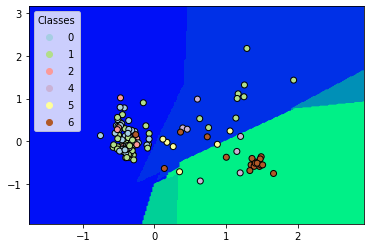

In [59]:
draw_plot(X_train, y_train, clf, ovo_predict)

### RBF Picking best gamma

In [60]:
gamma_grid = [1, 10, 100, 1000, 10000]

Gamma: 1
Train Accuracy 0.5503355704697986
Test Accuracy 0.5692307692307692


//anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


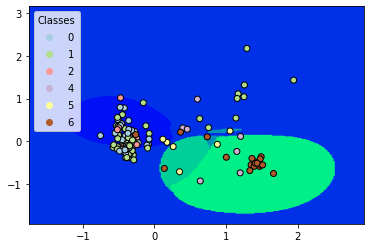


Gamma: 10
Train Accuracy 0.6912751677852349
Test Accuracy 0.6153846153846154


//anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


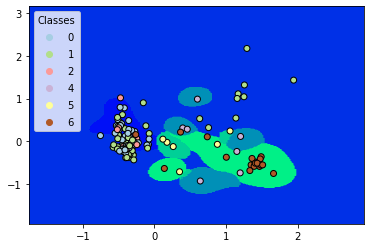


Gamma: 100
Train Accuracy 0.7986577181208053
Test Accuracy 0.6


//anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


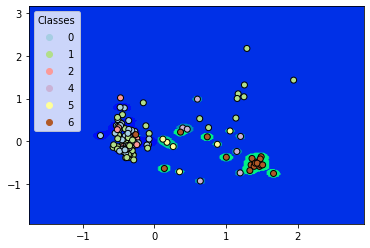


Gamma: 1000
Train Accuracy 0.9261744966442953
Test Accuracy 0.5846153846153846


//anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


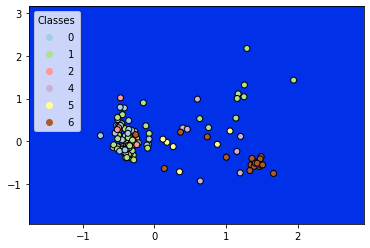


Gamma: 10000
Train Accuracy 0.9932885906040269
Test Accuracy 0.4153846153846154


//anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


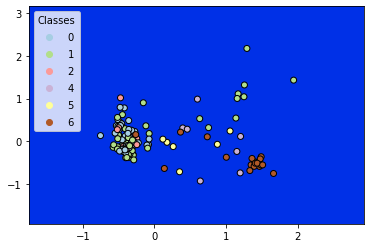

In [61]:
for gamma in gamma_grid:
    print("Gamma:", gamma)
    clf, combinations = ovo_fit(X_train, y_train, kernel='rbf', gamma=gamma)
    print("Train Accuracy", ovo_score(X_train, y_train, clf))
    print("Test Accuracy", ovo_score(X_test, y_test, clf))
    draw_plot(X_train, y_train, clf, ovo_predict)
    print("")

## Best gamma: 1 or 10

### kernel = 'rbf'

In [62]:
clf, combinations = ovo_fit(X_train, y_train, kernel='rbf', gamma=1)

In [63]:
ovo_score(X_train, y_train, clf)

0.5503355704697986

In [64]:
ovo_score(X_test, y_test, clf)

0.5692307692307692

//anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


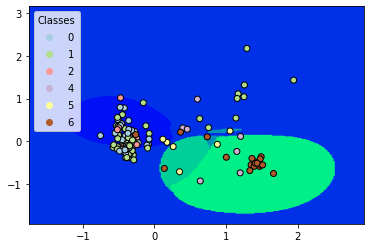

In [65]:
draw_plot(X_train, y_train, clf, ovo_predict)

# Part C: 10 fold CV

In [66]:
kf = KFold(n_splits=10)

Fold: 1
Train Accuracy 0.41044776119402987
Validation Accuracy 0.4666666666666667
Test Accuracy 0.47692307692307695


//anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


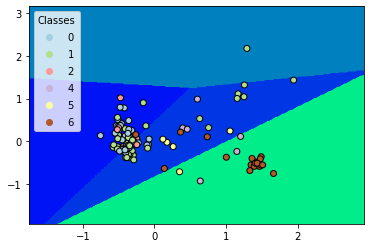


Fold: 2
Train Accuracy 0.4925373134328358
Validation Accuracy 0.3333333333333333
Test Accuracy 0.5384615384615384


//anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


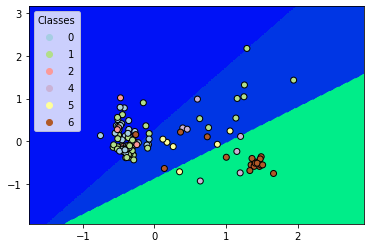


Fold: 3
Train Accuracy 0.41044776119402987
Validation Accuracy 0.4666666666666667
Test Accuracy 0.47692307692307695


//anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


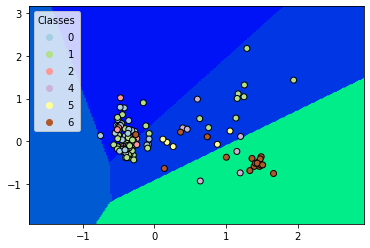


Fold: 4
Train Accuracy 0.373134328358209
Validation Accuracy 0.4
Test Accuracy 0.4307692307692308


//anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


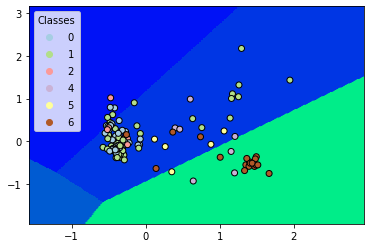


Fold: 5
Train Accuracy 0.3805970149253731
Validation Accuracy 0.4666666666666667
Test Accuracy 0.4


//anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


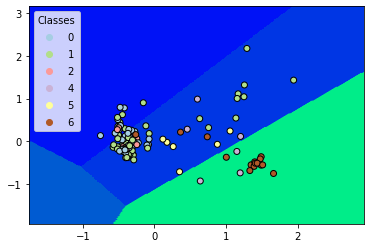


Fold: 6
Train Accuracy 0.3208955223880597
Validation Accuracy 0.2
Test Accuracy 0.24615384615384617


//anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


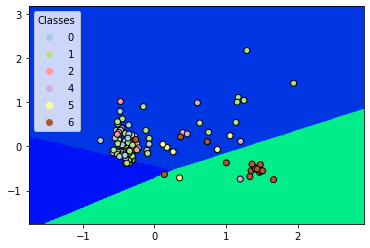


Fold: 7
Train Accuracy 0.34328358208955223
Validation Accuracy 0.4
Test Accuracy 0.38461538461538464


//anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


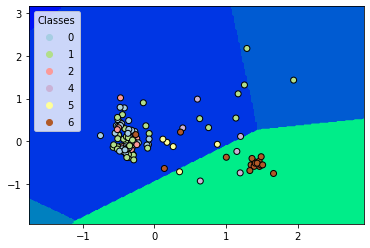


Fold: 8
Train Accuracy 0.3805970149253731
Validation Accuracy 0.2
Test Accuracy 0.38461538461538464


//anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


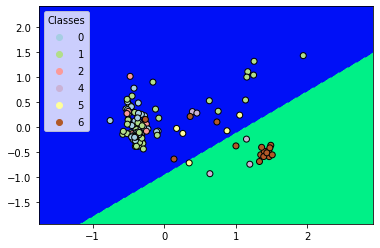


Fold: 9
Train Accuracy 0.4701492537313433
Validation Accuracy 0.3333333333333333
Test Accuracy 0.5538461538461539


//anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


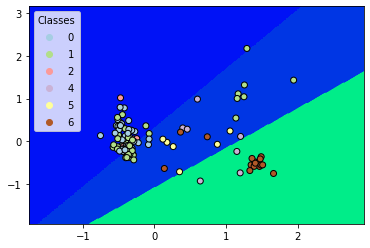


Fold: 10
Train Accuracy 0.43703703703703706
Validation Accuracy 0.21428571428571427
Test Accuracy 0.4461538461538462


//anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


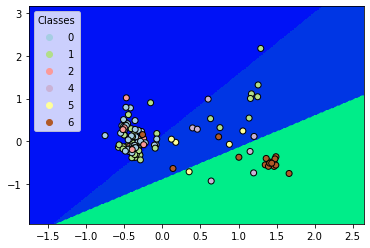

In [67]:
fold = 0
for train_index, test_index in kf.split(X_train):
    X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
    y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
    
    print("Fold:", fold + 1)
    clf = ovr_fit(X_train_cv, y_train_cv, probability, kernel='linear')
    print("Train Accuracy", ovr_score(X_train_cv, y_train_cv, clf))
    print("Validation Accuracy", ovr_score(X_test_cv, y_test_cv, clf))
    print("Test Accuracy", ovr_score(X_test, y_test, clf))
    draw_plot(X_train_cv, y_train_cv, clf, ovr_predict)
    print("")
    fold += 1

# Best fold: 2 and 8 as they perform best on the test set

# Appendix

In [68]:
# def ovr_predcit_proba(X_train, X_test, probability, svm_s):
#     y_prob_train, y_prob_test = [], []

#     for clf in svm_s:
# #         if probability:
#         y_prob_train.append(clf.predict_proba(X_train)[:, 1].tolist())
#         y_prob_test.append(clf.predict_proba(X_test)[:, 1].tolist())
# #         else:
# #             y_prob_train.append(clf.predict(X_train).tolist())
# #             y_prob_test.append(clf.predict(X_test).tolist())
#     return np.array(y_prob_train).T, np.array(y_prob_test).T

In [69]:
# def ovr_get_svms(X_train, y_train, kernel):

# #     grid = []
# #     for i in np.unique(y_train):
# #         grid.append((kernel, i))

#     svm_all = pool.map(ovr_svm_multipro, np.unique(y_train))

#     return svm_all

In [70]:
# def ovr_svm_multipro(kernel, i):
#     print("Processing Class y =", i)

#     y_train_ = copy.deepcopy(y_train)

#     y_train_[y_train_== i] = -1
#     y_train_[y_train_!= -1] = 0
#     y_train_[y_train_== -1] = 1

#     model = SVC(kernel=kernel, gamma='auto')
#     model.fit(X_train, y_train_)
#     print("Done:", i)
#     return model

In [71]:
### Train Test Split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=41)

In [72]:
# def linear_predict(x, w, b):
#     y_predicted = np.dot(x, w.T) + b
    
#     y_predicted[y_predicted>=0] = 1
#     y_predicted[y_predicted<0] = 0
#     return y_predicted

In [73]:
# svm = SVC(kernel=linear_kernel)

In [74]:
# %%time
# svm.fit(X_train, y_train)

In [75]:
# %%time
# svm.score(X_test, y_test)